## Classifier: In Context Learing - K Demonstrators

In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModelForCausalLM
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset, load_from_disk
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from utils.model import *

import numpy as np
import os
import time
import random
import torch

/root/.pyenv/versions/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Save and Output Results

In [2]:
from tabulate import tabulate

In [16]:
ks = [0, 2, 4, 6]
eval_results_all = {}

for k in ks:
    # Load the dictionary from the JSON file
    file_path = f"./eval_results_icl_{k}s_random_balanced.json"
    with open(file_path, "r") as file:
        eval_results = json.load(file)
        eval_results_all[k] = eval_results


In [17]:
eval_results_all

{0: {'CohereForAI/aya-101': {'cannabis': {'accuracy': 0.8159509202453987,
    'precision': 1.0,
    'recall': 0.7333333333333333,
    'f1': 0.8461538461538461},
   'energie': {'accuracy': 0.7852760736196319,
    'precision': 1.0,
    'recall': 0.4214876033057851,
    'f1': 0.5930232558139535},
   'kinder': {'accuracy': 0.7089552238805971,
    'precision': 1.0,
    'recall': 0.2777777777777778,
    'f1': 0.43478260869565216}}},
 2: {'CohereForAI/aya-101': {'cannabis': {'accuracy': 0.911042944785276,
    'precision': 0.9851485148514851,
    'recall': 0.8844444444444445,
    'f1': 0.9320843091334895},
   'energie': {'accuracy': 0.7730061349693251,
    'precision': 1.0,
    'recall': 0.3884297520661157,
    'f1': 0.5595238095238095},
   'kinder': {'accuracy': 0.8507462686567164,
    'precision': 0.9722222222222222,
    'recall': 0.6481481481481481,
    'f1': 0.7777777777777778}}},
 4: {'CohereForAI/aya-101': {'cannabis': {'accuracy': 0.901840490797546,
    'precision': 0.966183574879227,
 

In [18]:
# Identify all topics (assuming all models are evaluated on the same topics)
topics = list(next(iter(eval_results.values())).keys())

# Prepare headers for the table: each topic will have four metrics
headers = ["Model"] + \
    [f"{topic} {metric}" for topic in topics for metric in [
        "Acc.", "Prec.", "Rec.", "F1"]]

# Prepare rows: one row per model, containing metrics for each topic
rows = []
for model_name, topics_metrics in eval_results.items():
    row = [model_name]  # Start with the model name
    for topic in topics:
        metrics = topics_metrics.get(topic, {})
        row.extend([metrics.get('accuracy', 0.0), metrics.get(
            'precision', 0.0), metrics.get('recall', 0.0), metrics.get('f1', 0.0)])
    rows.append(row)

# Generate the HTML table
table_html = tabulate(rows, headers=headers, tablefmt="html",
                      showindex="never", floatfmt=".3f")

In [19]:
from IPython.display import display, HTML
display(HTML(table_html))

Model,cannabis Acc.,cannabis Prec.,cannabis Rec.,cannabis F1,energie Acc.,energie Prec.,energie Rec.,energie F1,kinder Acc.,kinder Prec.,kinder Rec.,kinder F1
CohereForAI/aya-101,0.871,0.867,0.960,0.911,0.828,0.744,0.818,0.780,0.851,0.986,0.639,0.775


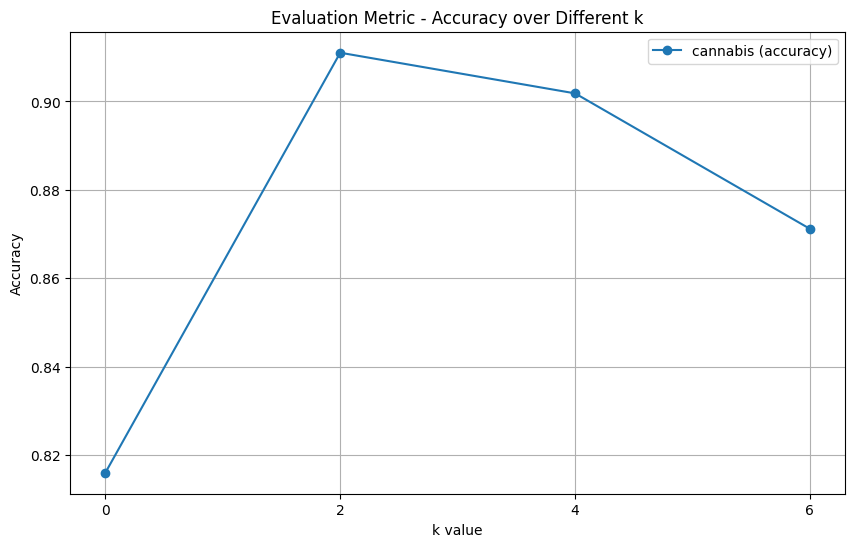

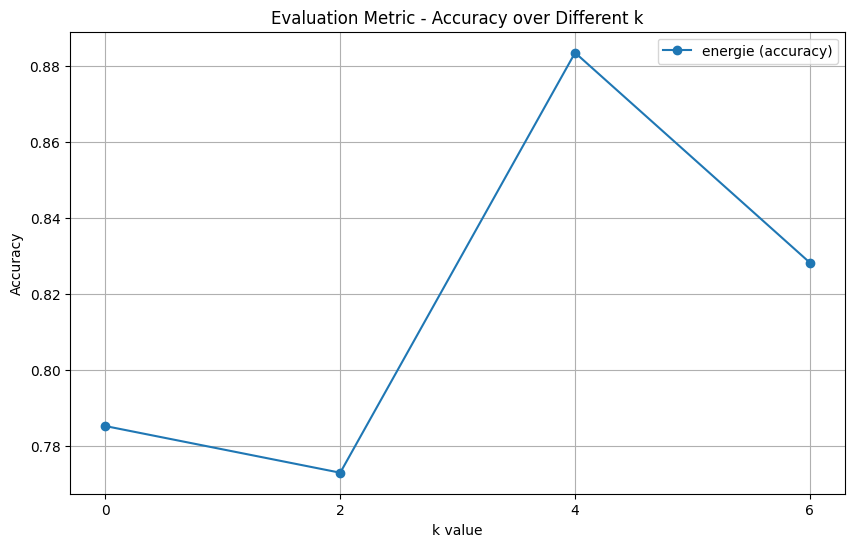

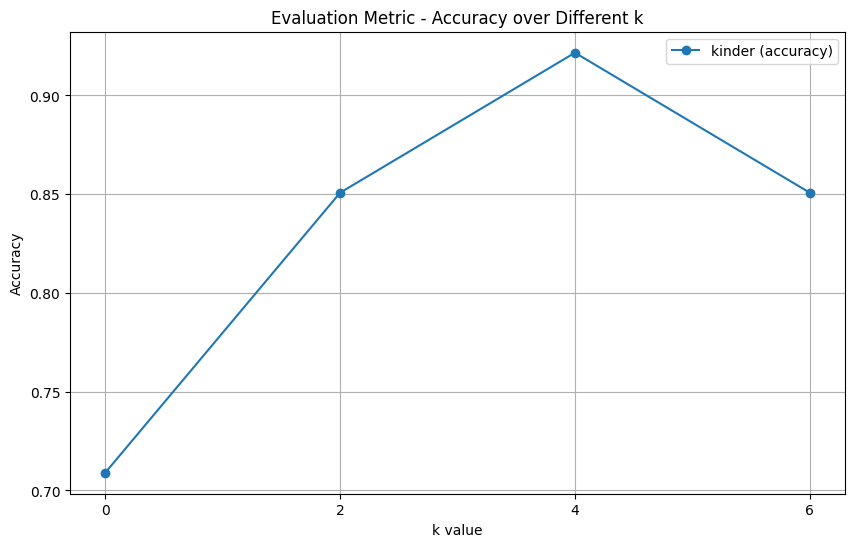

In [22]:
# Function to extract and plot metrics
def plot_evaluation_metrics(results, metric):
    # Unpack and organize the data
    data = defaultdict(dict)
    for k, entries in results.items():
        for model, topics in entries.items():
            for topic, metrics in topics.items():
                if topic not in data:
                    data[topic] = defaultdict(list)
                data[topic][metric].append(metrics[metric])
                data[topic]['k'].append(k)

    # Plot each topic's metric
    for topic, metrics in data.items():
        plt.figure(figsize=(10, 6))
        plt.plot(metrics['k'], metrics[metric], marker='o', label=f'{topic} ({metric})')
        plt.title(f'Evaluation Metric - {metric.capitalize()} over Different k')
        plt.xlabel('k value')
        plt.ylabel(metric.capitalize())
        plt.xticks(metrics['k'])  # Ensures only the 'k' values used are shown
        plt.grid(True)
        plt.legend()
        plt.show()

# Call the function to plot a specific metric, e.g., 'f1'
plot_evaluation_metrics(eval_results_all, 'accuracy')

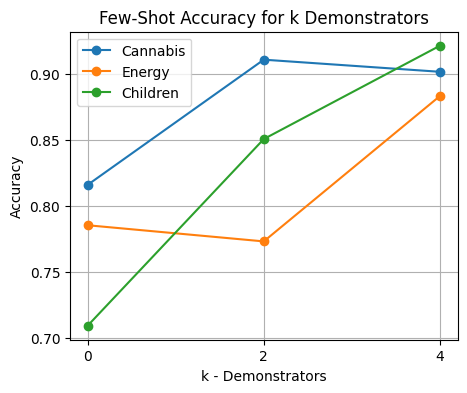

In [42]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Function to extract and plot metrics
def plot_evaluation_metrics(results, metric):
    # Unpack and organize the data
    data = defaultdict(dict)
    topic_mapping = {"cannabis": "Cannabis", "energie": "Energy", "kinder": "Children"}  # Map original topics to new names
    for k, entries in results.items():
        if k < 6:
            for model, topics in entries.items():
                for topic, metrics in topics.items():
                    mapped_topic = topic_mapping.get(topic, topic)  # Get mapped name, defaulting to original if not found
                    if mapped_topic not in data:
                        data[mapped_topic] = defaultdict(list)
                    data[mapped_topic][metric].append(metrics[metric])
                    data[mapped_topic]['k'].append(k)

    # Create a single plot for all topics
    plt.figure(figsize=(5, 4))
    for topic, metrics in data.items():
        plt.plot(metrics['k'], metrics[metric], marker='o', label=f'{topic}')

    # Configure and display the combined plot
    plt.title(f'Few-Shot {metric.capitalize()} for k Demonstrators')
    plt.xlabel('k - Demonstrators')
    plt.ylabel(metric.capitalize())
    plt.xticks(list(data.values())[0]['k'])  # Assumes 'k' values are the same for all topics
    plt.grid(True)
    plt.legend()
    plt.savefig('./few_shot_for_k.pdf', format='pdf')
    plt.show()

plot_evaluation_metrics(eval_results_all, 'accuracy')